# Transformers for chemical reactions - reaction prediction


![](https://pubs.acs.org/cms/10.1021/acscentsci.9b00576/asset/images/medium/oc9b00576_0009.gif)
</br><center>Figure 1: SMILES-to-SMILES translation with the Molecular Transformer</center>

## Table of content:
#### Setup
* [Data download](#first-bullet)
* [Load the data](#second-bullet)
* [Tokenization](#third-bullet)

#### OpenNMT-py main steps
* [Building the vocab](#fourth-bullet)
* [Training the Molecular Transformer](#fifth-bullet)
* [Testing](#sixth-bullet)

#### Additional stuff
* [Improvements](#seventh-bullet)
* [Further steps](#eighth-bullet)
* [Publications](#ninth-bullet)

We start by installing [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py), a common Python neural machine translation framework, and [RDKit](https://www.rdkit.org), the open-source python cheminformatics Swiss army knife.

In [5]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install rdkit-pypi==2022.3.1
    !pip install pip install OpenNMT-py==2.2.0

In [70]:
import gdown
import os
import random
import re

import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()
from rdkit import Chem

# to display molecules
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True


# disable RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 

# Data download <a class="anchor" id="first-bullet"></a>

In this short tutorial, we will look at USPTO_480k, which is a frequently used reaction prediction benchmark dataset. Please note that it does not contain stereochemistry. The original USPTO data can be downloaded from [figshare](https://figshare.com/articles/dataset/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873).

In [68]:
def download_data():
    # links from https://github.com/coleygroup/Graph2SMILES/blob/main/scripts/download_raw_data.py
    USPTO_480k_links= [
            ("https://drive.google.com/uc?id=1RysNBvB2rsMP0Ap9XXi02XiiZkEXCrA8", "src-train.txt"),
            ("https://drive.google.com/uc?id=1CxxcVqtmOmHE2nhmqPFA6bilavzpcIlb", "tgt-train.txt"),
            ("https://drive.google.com/uc?id=1FFN1nz2yB4VwrpWaBuiBDzFzdX3ONBsy", "src-val.txt"),
            ("https://drive.google.com/uc?id=1pYCjWkYvgp1ZQ78EKQBArOvt_2P1KnmI", "tgt-val.txt"),
            ("https://drive.google.com/uc?id=10t6pHj9yR8Tp3kDvG0KMHl7Bt_TUbQ8W", "src-test.txt"),
            ("https://drive.google.com/uc?id=1FeGuiGuz0chVBRgePMu0pGJA4FVReA-b", "tgt-test.txt")
        ]
    data_path = 'USPTO_480k'
    os.makedirs(data_path, exist_ok=True)
    for url, name in USPTO_480k_links:
        target_path = os.path.join(data_path, name)
        if not os.path.exists(target_path):
            gdown.download(url, target_path, quiet=False)
        else:
            print(f"{target_path} already exists")

def canonicalize_smiles(smiles, verbose=False): # will raise an Exception if invalid SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        if verbose:
            print(f'{smiles} is invalid.')
        return ''


In [7]:
!rm -rf sample_data
download_data()

USPTO_480k/src-train.txt already exists
USPTO_480k/tgt-train.txt already exists
USPTO_480k/src-val.txt already exists
USPTO_480k/tgt-val.txt already exists
USPTO_480k/src-test.txt already exists
USPTO_480k/tgt-test.txt already exists


# Load the data <a class="anchor" id="second-bullet"></a>

Ideally you would make sure that all SMILES are canonicalized but here we will skip this for time reasons and assume that all SMILES were already canonicalized. The full canonicalization could take ~20 minutes.

```python
line_count = !cat USPTO_480k/src-train.txt | wc -l
total = int(line_count[0])
with open('USPTO_480k/src-train.txt', 'r') as f:
    precursors_train = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
with open('USPTO_480k/tgt-train.txt', 'r') as f:
    products_train = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
    
line_count = !cat USPTO_480k/src-val.txt | wc -l
total = int(line_count[0])
with open('USPTO_480k/src-val.txt', 'r') as f:
    precursors_val = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
with open('USPTO_480k/tgt-val.txt', 'r') as f:
    products_val = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
    
line_count = !cat USPTO_480k/src-test.txt | wc -l
total = int(line_count[0])
with open('USPTO_480k/src-test.txt', 'r') as f:
    precursors_test = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
with open('USPTO_480k/tgt-test.txt', 'r') as f:
    products_test = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
```

Here we will simply read the data and load it into pandas dataframes:

In [43]:
with open('USPTO_480k/src-train.txt', 'r') as f:
    precursors_train = [line.strip().replace(' ', '') for line in f]
with open('USPTO_480k/tgt-train.txt', 'r') as f:
    products_train = [line.strip().replace(' ', '') for line in f]
with open('USPTO_480k/src-val.txt', 'r') as f:
    precursors_val = [line.strip().replace(' ', '') for line in f]
with open('USPTO_480k/tgt-val.txt', 'r') as f:
    products_val = [line.strip().replace(' ', '') for line in f]
with open('USPTO_480k/src-test.txt', 'r') as f:
    precursors_test = [line.strip().replace(' ', '') for line in f]
with open('USPTO_480k/tgt-test.txt', 'r') as f:
    products_test = [line.strip().replace(' ', '') for line in f]

In [44]:
train_df = pd.DataFrame({'precursors': precursors_train, 'products': products_train})
print(f"The training set contains {train_df.shape[0]} reactions.")
train_df.head()

The training set contains 409035 reactions.


,precursors,products
0,C1CCOC1.CC(C)C[Mg+].CON(C)C(=O)c1ccc(O)nc1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1
1,CN.O.O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,CNc1ccc(C(=O)O)cc1[N+](=O)[O-]
2,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21....,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21
3,CC(C)=C(Cl)N(C)C.COCC(C)Oc1cc(Oc2cnc(C(=O)N3CC...,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...
4,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1.NCc1ccc(Cl)c(Cl)c1,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1


In [45]:
val_df = pd.DataFrame({'precursors': precursors_val, 'products': products_val})
print(f"The validation set contains {val_df.shape[0]} reactions.")
val_df.head()

The validation set contains 30000 reactions.


,precursors,products
0,CC(C)=O.COc1ccc(S(=O)(=O)Cl)cc1.[I-].[Na+],COc1ccc(S(=O)[O-])cc1
1,CC(C)(C)[O-].N#Cc1c(N)nc(Cl)c(C#N)c1-c1ccccc1....,N#Cc1c(N)nc(OCc2ccccn2)c(C#N)c1-c1ccccc1
2,C1CCOC1.CCCCCCC.CN1CCC(CCO)CC1.Cc1ccc(N2CCN(C(...,Cc1ccc(N2CCN(C(=O)OCCC3CCN(C)CC3)CC2)cc1
3,CC(C)(C)OC(=O)N1CCC(COC(=O)C2CCC3CN2C(=O)N3OS(...,O=C(OCC1CCNCC1)C1CCC2CN1C(=O)N2OS(=O)(=O)O
4,CCC12CCC3C4CCC(=O)C=C4CCC3C1C(O)CC2=O.ClCCl.O....,CCC12CCC3C4CCC(=O)C=C4CCC3C1C(OC(=O)c1ccccc1)C...


In [46]:
test_df = pd.DataFrame({'precursors': precursors_test, 'products': products_test})
print(f"The test set contains {test_df.shape[0]} reactions.")
test_df.head()

The test set contains 40000 reactions.


,precursors,products
0,C1CCOC1.N#Cc1ccsc1N.O=[N+]([O-])c1cc(F)c(F)cc1...,N#Cc1ccsc1Nc1cc(F)c(F)cc1[N+](=O)[O-]
1,CCCCP(CCCC)CCCC.COC(=O)Cc1cn(C)c2cc(O)ccc12.Cc...,COC(=O)Cc1cn(C)c2cc(OCC(C)c3cn(-c4ccc(C(F)(F)F...
2,CCOCC.Cl.Cl.ClC(Cl)Cl.NC1CCN(CC2Cn3c(=O)ccc4nc...,O=c1ccc2ncc(F)c3c2n1CC3CN1CCC(NCc2cc3c(cn2)OCS...
3,C=C(C)C(=O)Cl.CC(C)=C1C(=O)N(c2ccc(O)cc2)C(=O)...,C=C(C)C(=O)Oc1ccc(N2C(=O)C(=C(C)C)C(=C(C)c3cc(...
4,O=Cc1cncc(Cl)c1COC1CCCCO1.OCc1c(Cl)cncc1Cl,OCc1cncc(Cl)c1COC1CCCCO1


## Sanity check - canoncalization
There is no standard for the canonicalization of SMILES. We might find SMILES that differ... A potential reason for this is that the canonicalization has changed with a newer RDKit version. So, always state the RDKit version that you are working with.

In [33]:
line_count = !cat USPTO_480k/src-val.txt | wc -l
total = int(line_count[0])+1
with open('USPTO_480k/src-val.txt', 'r') as f:
    can_precursors_val = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]

for smiles, can_smiles in zip(precursors_val, can_precursors_val):
    try:
        assert smiles == can_smiles
    except AssertionError:
        print(smiles)
        print(can_smiles)
    break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:06<00:00, 4499.37it/s]


# Tokenization <a class="anchor" id="third-bullet"></a>

To be able to train a language model, we need to split the strings into tokens.

We take the regex pattern introduced in the [Molecular Transformer](https://pubs.acs.org/doi/abs/10.1021/acscentsci.9b00576).

In [17]:
SMI_REGEX_PATTERN =  r"(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

def smiles_tokenizer(smiles):
    smiles_regex = re.compile(SMI_REGEX_PATTERN)
    tokens = [token for token in smiles_regex.findall(smiles)]
    return ' '.join(tokens)

In [18]:
print('Tokenizing training set')
train_df['tokenized_precursors'] = train_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
train_df['tokenized_products'] = train_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing validation set')
val_df['tokenized_precursors'] = val_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
val_df['tokenized_products'] = val_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing test set')
test_df['tokenized_precursors'] = test_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
test_df['tokenized_products'] = test_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))

Tokenizing training set
Tokenizing validation set
Tokenizing test set


## Save the preprocessed data set

Don't forget to shuffle the training set before saving it. At least earlier versions of OpenNMT-py would not shuffle it during preprocessing.

In [19]:
shuffled_train_df = train_df.sample(frac=1., random_state=42)

In [20]:
data_path = 'USPTO_480k_preprocessed'

os.makedirs(data_path, exist_ok=True)
with open(os.path.join(data_path, 'precursors-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_train_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_train_df.tokenized_products.values))

with open(os.path.join(data_path, 'precursors-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_products.values))
    
with open(os.path.join(data_path, 'precursors-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_products.values))

# Building the vocab <a class="anchor" id="fourth-bullet"></a>

The first step for the [OpenNMT-py pipeline](https://opennmt.net/OpenNMT-py/quickstart.html) is to build the vocabulary.

![](https://camo.githubusercontent.com/69fb11841ce1abd51a3fd7f3ed4b424857029ce123521cc301eb48a1e22bee2f/687474703a2f2f6f70656e6e6d742e6769746875622e696f2f73696d706c652d6174746e2e706e67)
</br><center>Figure 2: In contrast to a neural machine translation model for human language, we will use an atom-wise vocabulary. </center>


Please note:
- Typical sequence pairs in machine translation are much shorter than the ones you encounter in chemical reaction prediction. Hence, set a `src_seq_length` and `tgt_seq_length` that is much higher than the maximum you would expect to include all reactions.
- With `n_sample` set to `-1` we include the whole dataset.

The paths to the training and validation datasets are defined in the `run_config.yaml`:

```yaml
# https://opennmt.net/OpenNMT-py/quickstart.html
# Examples in https://github.com/OpenNMT/OpenNMT-py/tree/master/config

## Where the samples will be written
save_data: example_run
## Where the vocab(s) will be written
src_vocab: example_run/uspto.vocab.src
tgt_vocab: example_run/uspto.vocab.src
# Prevent overwriting existing files in the folder
overwrite: true
share_vocab: true

# Corpus opts:
data:
    corpus-1:
        path_src: USPTO_480k_preprocessed/precursors-train.txt
        path_tgt: USPTO_480k_preprocessed/products-train.txt
    valid:
        path_src: USPTO_480k_preprocessed/precursors-val.txt
        path_tgt: USPTO_480k_preprocessed/products-val.txt
```

As the source (precusors) and the target (products) are represented as SMILES and consist of the same tokens, we share the vocabulary between source and target (`share_vocab: true`). 

In [21]:
! onmt_build_vocab -config example_run/run_config.yaml \
    -src_seq_length 1000 -tgt_seq_length 1000 \
    -src_vocab_size 1000 -tgt_vocab_size 1000 \
    -n_sample -1

Corpus corpus-1's weight should be given. We default it to 1 for you.
[2022-04-17 08:53:57,969 INFO] Counter vocab from -1 samples.
[2022-04-17 08:53:57,969 INFO] n_sample=-1: Build vocab on full datasets.
[2022-04-17 08:53:57,972 INFO] corpus-1's transforms: TransformPipe()
[2022-04-17 08:54:01,980 INFO] Counters src:281
[2022-04-17 08:54:01,980 INFO] Counters tgt:128
[2022-04-17 08:54:01,980 INFO] Counters after share:292


# Training the Molecular Transformer <a class="anchor" id="fifth-bullet"></a>

If you look at the `run_config.yaml`, you will see that we have defined some of the training parameters (but not yet the hyperparameters of the model.

```yaml
# Train on a single GPU
world_size: 1
gpu_ranks: [0]

# Where to save the checkpoints
save_model: example_run/model
save_checkpoint_steps: 5000
keep_checkpoint: 3
train_steps: 400000
valid_steps: 10000
report_every: 100

tensorboard: true
tensorboard_log_dir: log_dir
```

The Transformer architecture was published in the [Attention is all you need](https://proceedings.neurips.cc/paper/7181-attention-is-all-you-need) paper by Vaswani et al. (NeurIPS, 2017). The model sizes (65 to 212M parameters) in that paper were larger than what we use for reaction prediction (20M parameters). 

![](https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter01_self-attention.png)
</br><center>Figure 3: Transformer model (source: https://github.com/nlp-with-transformers). </center>

Illustrated transformer blogposts:
- https://nlp.seas.harvard.edu/2018/04/03/attention.html
- https://jalammar.github.io/illustrated-transformer/

In [55]:
# hyperparameters from https://github.com/rxn4chemistry/OpenNMT-py/tree/carbohydrate_transformer
!onmt_train -config example_run/run_config.yaml \
        -seed 42 -gpu_ranks 0  \
        -param_init 0 \
        -param_init_glorot -max_generator_batches 32 \
        -batch_type tokens -batch_size 6144\
         -normalization tokens -max_grad_norm 0  -accum_count 4 \
        -optim adam -adam_beta1 0.9 -adam_beta2 0.998 -decay_method noam  \
        -warmup_steps 8000 -learning_rate 2 -label_smoothing 0.0 \
        -layers 4 -rnn_size  384 -word_vec_size 384 \
        -encoder_type transformer -decoder_type transformer \
        -dropout 0.1 -position_encoding -share_embeddings  \
        -global_attention general -global_attention_function softmax \
        -self_attn_type scaled-dot -heads 8 -transformer_ff 2048 \
        -tensorboard True -tensorboard_log_dir log_dir

[2022-04-18 21:25:12,694 INFO] Missing transforms field for corpus-1 data, set to default: [].
[2022-04-18 21:25:12,694 WARNING] Corpus corpus-1's weight should be given. We default it to 1 for you.
[2022-04-18 21:25:12,694 INFO] Missing transforms field for valid data, set to default: [].
[2022-04-18 21:25:12,694 INFO] Parsed 2 corpora from -data.
[2022-04-18 21:25:12,694 INFO] Get special vocabs from Transforms: {'src': set(), 'tgt': set()}.
[2022-04-18 21:25:12,694 INFO] Loading vocab from text file...
[2022-04-18 21:25:12,694 INFO] Loading src vocabulary from example_run/uspto.vocab.src
[2022-04-18 21:25:12,695 INFO] Loaded src vocab has 292 tokens.
[2022-04-18 21:25:12,695 INFO] Loading tgt vocabulary from example_run/uspto.vocab.src
[2022-04-18 21:25:12,696 INFO] Loaded tgt vocab has 292 tokens.
[2022-04-18 21:25:12,696 INFO] Building fields with vocab in counters...
[2022-04-18 21:25:12,696 INFO]  * tgt vocab size: 296.
[2022-04-18 21:25:12,697 INFO]  * src vocab size: 294.
[202

[2022-04-18 21:25:14,423 INFO] Starting training on GPU: [0]
[2022-04-18 21:25:14,423 INFO] Start training loop and validate every 10000 steps...
[2022-04-18 21:25:14,423 INFO] corpus-1's transforms: TransformPipe()
[2022-04-18 21:25:14,423 INFO] Weighted corpora loaded so far:
			* corpus-1: 1
^C
Traceback (most recent call last):
  File "/home/schwalle/miniconda3/envs/dmds/bin/onmt_train", line 8, in <module>
    sys.exit(main())
  File "/home/schwalle/miniconda3/envs/dmds/lib/python3.7/site-packages/onmt/bin/train.py", line 172, in main
    train(opt)
  File "/home/schwalle/miniconda3/envs/dmds/lib/python3.7/site-packages/onmt/bin/train.py", line 157, in train
    train_process(opt, device_id=0)
  File "/home/schwalle/miniconda3/envs/dmds/lib/python3.7/site-packages/onmt/train_single.py", line 114, in main
    valid_steps=opt.valid_steps)
  File "/home/schwalle/miniconda3/envs/dmds/lib/python3.7/site-packages/onmt/trainer.py", line 244, in train
    report_stats)
  File "/home/schwa

The training can take more than 24 hours on a single GPU. Hence, we will download the trained model.

In [41]:
trained_model_url = 'https://drive.google.com/uc?id=1ywJCJHunoPTB5wr6KdZ8aLv7tMFMBHNy'
model_folder = 'models'
model_name = 'USPTO480k_model_step_400000.pt'

os.makedirs(model_folder, exist_ok=True)
target_path = os.path.join(model_folder, model_name)
if not os.path.exists(target_path):
    gdown.download(trained_model_url, target_path, quiet=False)
else:
    print(f"{target_path} already exists")

models/USPTO480k_model_step_400000.pt already exists


# Evaluating the model <a class="anchor" id="sixth-bullet"></a>

In [57]:
!onmt_translate -model models/USPTO480k_model_step_400000.pt -gpu 0 \
    --src USPTO_480k_preprocessed/precursors-val.txt \
    --tgt USPTO_480k_preprocessed/products-val.txt \
    --output results/USPTO480k_model_step_400000_val_predictions.txt \
    --n_best 5 --beam_size 10 --max_length 300 --batch_size 64

[2022-04-18 21:34:47,589 INFO] Translating shard 0.
/home/schwalle/miniconda3/envs/dmds/lib/python3.7/site-packages/onmt/translate/beam_search.py:282: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._batch_index = self.topk_ids // vocab_size
[2022-04-18 21:37:04,690 INFO] PRED AVG SCORE: -0.0010, PRED PPL: 1.0010
[2022-04-18 21:37:04,690 INFO] GOLD AVG SCORE: -0.0404, GOLD PPL: 1.0413
[2022-04-18 21:37:04,721 INFO] Translating shard 1.
[2022-04-18 21:39:23,815 INFO] PRED AVG SCORE: -0.0010, PRED PPL: 1.0010
[2022-04-18 21:39:23,815 INFO] GOLD AVG SCORE: -0.0420, GOLD PPL: 1.0428
[2022-04-18 21:39:23,848 INFO] Translating shard 2.
[2022-04-18 21:41:42,104 IN

In [82]:
# https://github.com/pschwllr/MolecularTransformer/blob/master/score_predictions.py

n_best = 5 # top-5 predictions were outputted
predictions = [[] for i in range(n_best)]

with open('USPTO_480k_preprocessed/products-val.txt', 'r') as f:
    targets = [line.strip().replace(' ', '') for line in f]

evaluation_df = pd.DataFrame(targets)
evaluation_df.columns = ['target']

with open('USPTO_480k_preprocessed/precursors-val.txt', 'r') as f:
    precursors = [line.strip().replace(' ', '') for line in f]
evaluation_df['precursors'] = precursors

total = len(evaluation_df)

with open('results/USPTO480k_model_step_400000_val_predictions_precomputed.txt', 'r') as f:
    
    for i, line in enumerate(f):
        predictions[i % n_best].append(''.join(line.strip().split(' ')))
for i, preds in enumerate(predictions):
    evaluation_df['prediction_{}'.format(i + 1)] = preds
    evaluation_df['canonical_prediction_{}'.format(i + 1)] = evaluation_df['prediction_{}'.format(i + 1)].progress_apply(
        lambda x: canonicalize_smiles(x))

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

In [83]:
def get_rank(row, col_name, max_rank):
    for i in range(1, max_rank+1):
        if row['target'] == row['{}{}'.format(col_name, i)]:
            return i
    return 0
evaluation_df['rank'] = evaluation_df.progress_apply(lambda row: get_rank(row, 'canonical_prediction_', n_best), axis=1)

correct = 0

for i in range(1, n_best+1):
    correct += (evaluation_df['rank'] == i).sum()
    invalid_smiles = (test_df['canonical_prediction_{}'.format(i)] == '').sum()
    
    print('Top-{}: {:.1f}% || Invalid SMILES {:.2f}%'.format(i, correct/total*100,
                                                                 invalid_smiles/total*100))
    

  0%|          | 0/30000 [00:00<?, ?it/s]

Top-1: 87.6% || Invalid SMILES 0.34%
Top-2: 90.7% || Invalid SMILES 15.12%
Top-3: 91.6% || Invalid SMILES 20.93%
Top-4: 92.1% || Invalid SMILES 24.14%
Top-5: 92.4% || Invalid SMILES 27.78%


## Let's draw some of the reactions 

In [87]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, display


# https://gist.github.com/greglandrum/61c1e751b453c623838759609dc41ef1
def draw_chemical_reaction(smiles,useSmiles=True,  highlightByReactant=False, notesAtomMaps=True, font_scale=1.5):
    rxn = rdChemReactions.ReactionFromSmarts(smiles,useSmiles=useSmiles)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    # move atom maps to be annotations:
    if notesAtomMaps:
        for m in trxn.GetReactants():
            moveAtomMapsToNotes(m)
        for m in trxn.GetProducts():
            moveAtomMapsToNotes(m)
    d2d = rdMolDraw2D.MolDraw2DSVG(800,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)
    d2d.FinishDrawing()

    return d2d.GetDrawingText()

def moveAtomMapsToNotes(m):
    for at in m.GetAtoms():
        if at.GetAtomMapNum():
            at.SetProp("atomNote",str(at.GetAtomMapNum()))


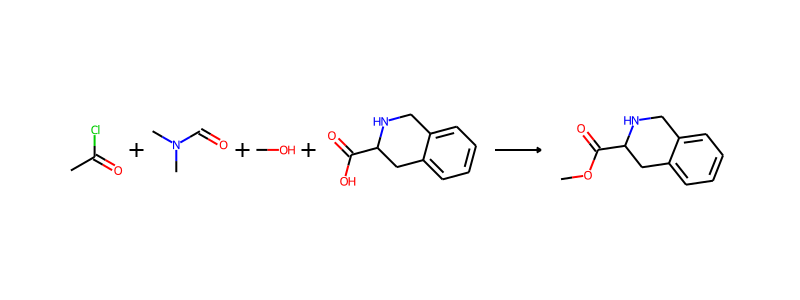

CC(=O)Cl.CN(C)C=O.CO.O=C(O)C1Cc2ccccc2CN1>>COC(=O)C1Cc2ccccc2CN1


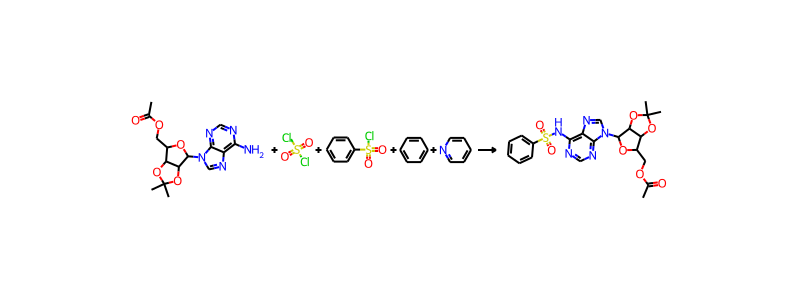

CC(=O)OCC1OC(n2cnc3c(N)ncnc32)C2OC(C)(C)OC12.O=S(=O)(Cl)Cl.O=S(=O)(Cl)c1ccccc1.c1ccccc1.c1ccncc1>>CC(=O)OCC1OC(n2cnc3c(NS(=O)(=O)c4ccccc4)ncnc32)C2OC(C)(C)OC12


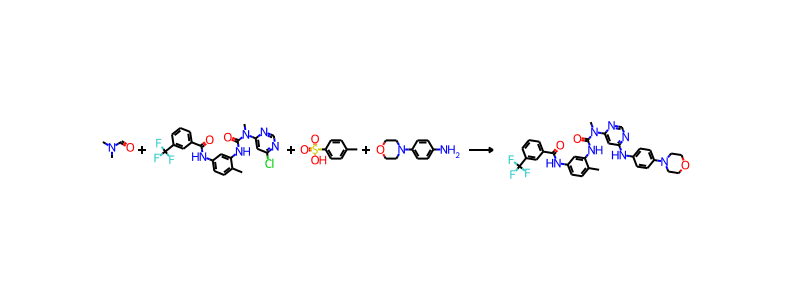

CN(C)C=O.Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1NC(=O)N(C)c1cc(Cl)ncn1.Cc1ccc(S(=O)(=O)O)cc1.Nc1ccc(N2CCOCC2)cc1>>Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1NC(=O)N(C)c1cc(Nc2ccc(N3CCOCC3)cc2)ncn1


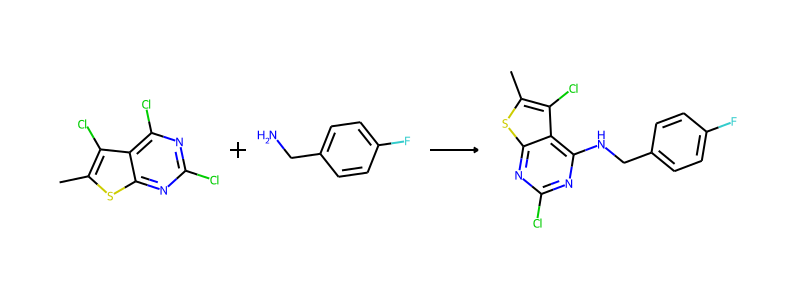

Cc1sc2nc(Cl)nc(Cl)c2c1Cl.NCc1ccc(F)cc1>>Cc1sc2nc(Cl)nc(NCc3ccc(F)cc3)c2c1Cl


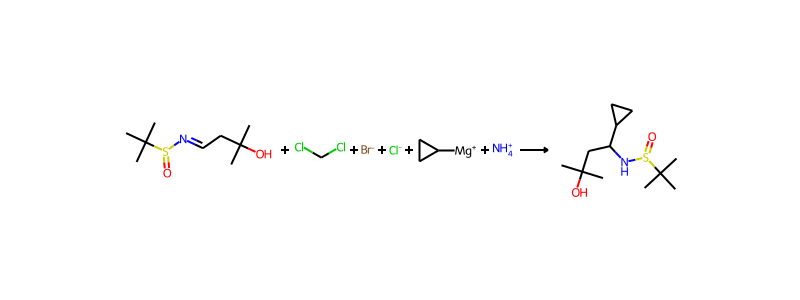

CC(C)(O)CC=NS(=O)C(C)(C)C.ClCCl.[Br-].[Cl-].[Mg+]C1CC1.[NH4+]>>CC(C)(O)CC(NS(=O)C(C)(C)C)C1CC1


In [93]:
for i, row in evaluation_df[evaluation_df['rank']==1].sample(5, random_state=1).iterrows():
    rxn_smiles = f"{row['precursors']}>>{row['canonical_prediction_1']}"
    display(SVG(draw_chemical_reaction(rxn_smiles)))
    print(rxn_smiles)

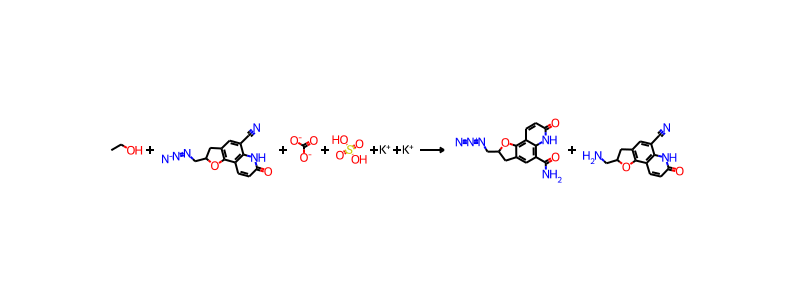

CCO.N#Cc1cc2c(c3ccc(=O)[nH]c13)OC(CN=[N+]=[N-])C2.O=C([O-])[O-].O=S(=O)(O)O.[K+].[K+]>>[N-]=[N+]=NCC1Cc2cc(C(N)=O)c3[nH]c(=O)ccc3c2O1.N#Cc1cc2c(c3ccc(=O)[nH]c13)OC(CN)C2


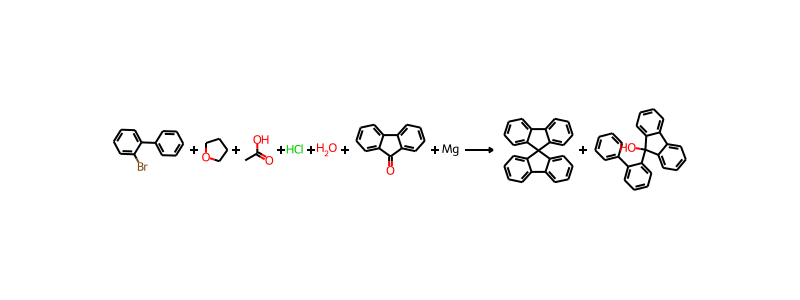

Brc1ccccc1-c1ccccc1.C1CCOC1.CC(=O)O.Cl.O.O=C1c2ccccc2-c2ccccc21.[Mg]>>c1ccc2c(c1)-c1ccccc1C21c2ccccc2-c2ccccc21.OC1(c2ccccc2-c2ccccc2)c2ccccc2-c2ccccc21


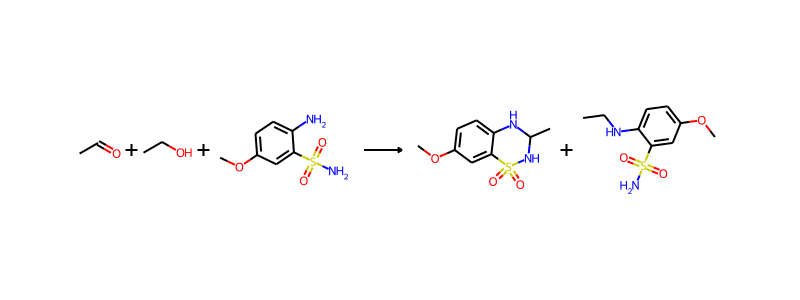

CC=O.CCO.COc1ccc(N)c(S(N)(=O)=O)c1>>COc1ccc2c(c1)S(=O)(=O)NC(C)N2.CCNc1ccc(OC)cc1S(N)(=O)=O


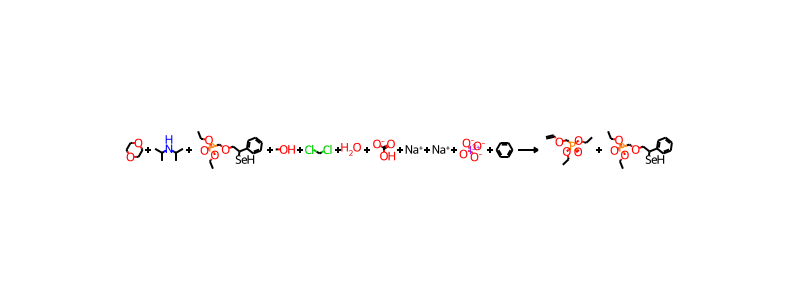

C1COCCO1.CC(C)NC(C)C.CCOP(=O)(COCC([SeH])c1ccccc1)OCC.CO.ClCCl.O.O=C([O-])O.[Na+].[Na+].[O-][I+3]([O-])([O-])[O-].c1ccccc1>>C=COCP(=O)(OCC)OCC.CCOP(=O)(COCC([SeH])c1ccccc1)OCC


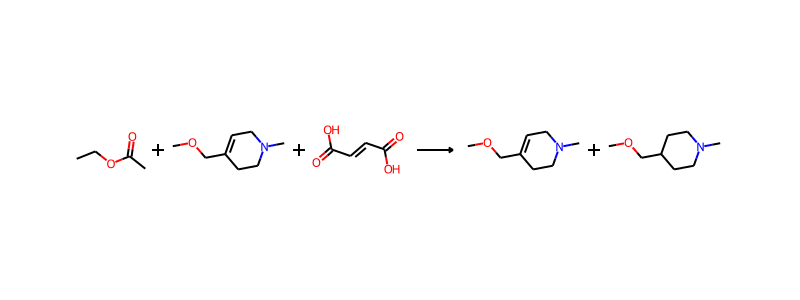

CCOC(C)=O.COCC1=CCN(C)CC1.O=C(O)C=CC(=O)O>>COCC1=CCN(C)CC1.COCC1CCN(C)CC1


In [94]:
for i, row in evaluation_df[evaluation_df['rank']==0].sample(5, random_state=1).iterrows():
    rxn_smiles = f"{row['precursors']}>>{row['target']}.{row['canonical_prediction_1']}"
    display(SVG(draw_chemical_reaction(rxn_smiles)))
    print(rxn_smiles)

# Improvements to the chemical reaction language models <a class="anchor" id="seventh-bullet"></a>

One of the improvements compared to the plain Molecular Transformer model, that was done in the past is data augmentation. 
- [Molecular Transformer](https://pubs.acs.org/doi/abs/10.1021/acscentsci.9b00576) -> one non-canonical copy of each precursors
- [Augmented Molecular Transformer](https://www.nature.com/articles/s41467-020-19266-y) -> extensive data augmentation on precursors and products sides

If you have a small dataset of more challenging reactions you could use transfer learning, as we explored in [Transfer learning enables the molecular transformer to predict regio- and stereoselective reactions on carbohydrates](https://www.nature.com/articles/s41467-020-18671-7).

## Data augmentations for reaction SMILES


In [48]:
# What if now we wanted to do some data augmentation on the training set

def randomize_smiles(smiles, random_type="rotated"):
    """
    # https://github.com/rxn4chemistry/rxn_yields/blob/master/nbs/06_data_augmentation.ipynb
    Inspired from: https://github.com/undeadpixel/reinvent-randomized and https://github.com/GLambard/SMILES-X
    Returns a random SMILES given a SMILES of a molecule.
    :param mol: A Mol object
    :param random_type: The type (unrestricted, restricted, rotated) of randomization performed.
    :return : A random SMILES string of the same molecule or None if the molecule is invalid.
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        print(f"{smiles} not valid.")
        return None

    if random_type == "unrestricted":
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=True)
    elif random_type == "restricted":
        new_atom_order = list(range(mol.GetNumAtoms()))
        random.shuffle(new_atom_order)
        random_mol = Chem.RenumberAtoms(mol, newOrder=new_atom_order)
        return Chem.MolToSmiles(random_mol, canonical=False, isomericSmiles=True)
    elif random_type == 'rotated':
        n_atoms = mol.GetNumAtoms()
        rotation_index = random.randint(0, n_atoms-1)
        atoms = list(range(n_atoms))
        new_atoms_order = (atoms[rotation_index%len(atoms):]+atoms[:rotation_index%len(atoms)])
        rotated_mol = Chem.RenumberAtoms(mol,new_atoms_order)
        return Chem.MolToSmiles(rotated_mol, canonical=False, isomericSmiles=True)
    raise ValueError("Type '{}' is not valid".format(random_type))

The canonical SMILES of this caffeine molecule is: Cn1c(=O)c2c(ncn2C)n(C)c1=O


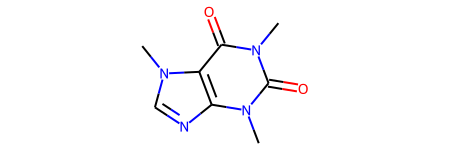

In [15]:
example_smi = 'O=C1C2=C(N=CN2C)N(C(=O)N1C)C'
mol = Chem.MolFromSmiles(example_smi)
print(f"The canonical SMILES of this caffeine molecule is: {Chem.MolToSmiles(mol)}")
mol

In [16]:
# different starting atom
rotated_random_smiles = []
for i in range (500):
    rotated_random_smiles.append(randomize_smiles(example_smi))
print(len(set(rotated_random_smiles)))
set(rotated_random_smiles)

14


{'Cn1c(=O)c2c(ncn2C)n(C)c1=O',
 'Cn1c2c(=O)n(C)c(=O)n(C)c2nc1',
 'Cn1c2c(c(=O)n(C)c1=O)n(C)cn2',
 'O=c1c2c(ncn2C)n(C)c(=O)n1C',
 'O=c1n(C)c(=O)c2c(ncn2C)n1C',
 'c1(=O)c2c(ncn2C)n(C)c(=O)n1C',
 'c1(=O)n(C)c(=O)c2c(ncn2C)n1C',
 'c12c(ncn1C)n(C)c(=O)n(C)c2=O',
 'c12ncn(C)c1c(=O)n(C)c(=O)n2C',
 'c1n(C)c2c(=O)n(C)c(=O)n(C)c2n1',
 'n1(C)c(=O)c2c(ncn2C)n(C)c1=O',
 'n1(C)c(=O)n(C)c(=O)c2c1ncn2C',
 'n1(C)c2c(=O)n(C)c(=O)n(C)c2nc1',
 'n1cn(C)c2c(=O)n(C)c(=O)n(C)c12'}

In [17]:
restricted_random_smiles = []
for i in range (500):
    restricted_random_smiles.append(randomize_smiles(example_smi, 'restricted'))
print(len(set(restricted_random_smiles)))
list(set(restricted_random_smiles))[:5]

76


['Cn1c(=O)n(C)c2c(c1=O)n(C)cn2',
 'c1(=O)n(C)c(=O)c2c(n1C)ncn2C',
 'Cn1c2c(=O)n(C)c(=O)n(C)c2nc1',
 'n1(C)c(=O)n(C)c(=O)c2c1ncn2C',
 'Cn1c(=O)c2c(ncn2C)n(C)c1=O']

In [18]:
unrestricted_random_smiles = []
for i in range (10000):
    unrestricted_random_smiles.append(randomize_smiles(example_smi, random_type='unrestricted'))
print(len(set(unrestricted_random_smiles)))
list(set(unrestricted_random_smiles))[:5]

1322


['c1(n(C)c(n(c2c1n(cn2)C)C)=O)=O',
 'c1(=O)c2c(n(C)c(n1C)=O)ncn2C',
 'Cn1c(=O)n(C)c(=O)c2n(C)cnc12',
 'c12c(n(C)cn1)c(=O)n(c(=O)n2C)C',
 'n1(C)c2ncn(C)c2c(n(C)c1=O)=O']

In [19]:
recanonicalised_smiles = set([Chem.MolToSmiles(Chem.MolFromSmiles(smiles)) for smiles in unrestricted_random_smiles])
assert len(recanonicalised_smiles) == 1
recanonicalised_smiles

{'Cn1c(=O)c2c(ncn2C)n(C)c1=O'}

In [ ]:
for i in range(5):
    print(randomize_smiles(can_smiles))

C1COCCO1.COc1cc2c3c(c1)c(=O)c(Cc1cccnc1)cn3-c1cc(Br)ccc1S2.N#CC1=C(C#N)C(=O)C(Cl)=C(Cl)C1=O
c1ncc(Cc2cn3c4c(cc(OC)cc4c2=O)Sc2c-3cc(Br)cc2)cc1.N#CC1=C(C#N)C(=O)C(Cl)=C(Cl)C1=O.C1COCCO1
C1(C#N)=C(C#N)C(=O)C(Cl)=C(Cl)C1=O.C1COCCO1.COc1cc2c3c(c1)c(=O)c(Cc1cccnc1)cn3-c1cc(Br)ccc1S2
c1cncc(Cc2cn3c4c(cc(OC)cc4c2=O)Sc2c-3cc(Br)cc2)c1.N#CC1=C(C#N)C(=O)C(Cl)=C(Cl)C1=O.C1COCCO1
n12c3c(cc(OC)cc3c(=O)c(Cc3cccnc3)c1)Sc1c-2cc(Br)cc1.N#CC1=C(C#N)C(=O)C(Cl)=C(Cl)C1=O.C1COCCO1


In [49]:
# we will include a rotated copy of all the training reactions

rotated_train_precursors = [randomize_smiles(precursors) for precursors in tqdm(train_df.precursors)]


 10%|████████████▌                                                                                                               | 41392/409035 [00:09<01:23, 4410.86it/s]


 20%|█████████████████████████▏                                                                                                  | 82904/409035 [00:18<01:13, 4418.30it/s]


 30%|█████████████████████████████████████▍                                                                                     | 124479/409035 [00:28<01:04, 4399.26it/s]


 41%|█████████████████████████████████████████████████▉                                                                         | 165963/409035 [00:37<00:56, 4337.86it/s]


 51%|██████████████████████████████████████████████████████████████▍                                                            | 207492/409035 [00:47<00:45, 4390.00it/s]


 61%|██████████████████████████████████████████████████████████████████████████▉                                                | 249137/409035 [00:56<00:36, 4439.76it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                   | 290664/409035 [01:06<00:27, 4355.51it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 332117/409035 [01:15<00:17, 4434.06it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 373660/409035 [01:25<00:07, 4427.04it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409035/409035 [01:33<00:00, 4378.75it/s]


In [50]:
rotated_train_df = pd.DataFrame({'precursors': rotated_train_precursors, 'products': products_train})
total_train_df = pd.concat([train_df, rotated_train_df])
total_train_df.shape


(818070, 2)

In [51]:
print('Tokenizing training set')
total_train_df['tokenized_precursors'] = total_train_df.precursors.apply(lambda smi: smiles_tokenizer(smi))
total_train_df['tokenized_products'] = total_train_df.products.apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing validation set')
val_df['tokenized_precursors'] = val_df.precursors.apply(lambda smi: smiles_tokenizer(smi))
val_df['tokenized_products'] = val_df.products.apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing test set')
test_df['tokenized_precursors'] = test_df.precursors.apply(lambda smi: smiles_tokenizer(smi))
test_df['tokenized_products'] = test_df.products.apply(lambda smi: smiles_tokenizer(smi))

Tokenizing training set
Tokenizing validation set
Tokenizing test set


In [52]:
# remember to shuffle your training data :)

shuffled_total_train_df = total_train_df.sample(frac=1., random_state=42)

In [53]:
shuffled_total_train_df.head()

,precursors,products,tokenized_precursors,tokenized_products
231516,BrCC1CCCCO1.N#Cc1cccc(CBr)c1.O=C1Nc2ccccc2C12C...,N#Cc1cccc(CN2C(=O)C3(COc4cc5c(cc43)OCCO5)c3ccc...,Br C C 1 C C C C O 1 . N # C c 1 c c c c ( C B...,N # C c 1 c c c c ( C N 2 C ( = O ) C 3 ( C O ...
233457,C(C)(C)(OC(=O)N1CCC(N)CC1)C.CCN(C(C)C)C(C)C.Cc...,Cc1cc(NC2CCN(C(=O)OC(C)(C)C)CC2)nc(Cl)n1,C ( C ) ( C ) ( O C ( = O ) N 1 C C C ( N ) C ...,C c 1 c c ( N C 2 C C N ( C ( = O ) O C ( C ) ...
272718,c1cc(OC)ccc1C1c2ccccc2C(c2ccc3c(c2)OCO3)C1C(OC...,COc1ccc(C2c3ccccc3C(c3ccc4c(c3)OCO4)C2C(=O)O)cc1,c 1 c c ( O C ) c c c 1 C 1 c 2 c c c c c 2 C ...,C O c 1 c c c ( C 2 c 3 c c c c c 3 C ( c 3 c ...
9817,C1CCOC1.CCCc1nn(C)c2c(=O)[nH]c(Cc3ccc(NC(C)=O)...,CCCc1nn(C)c2c(=O)[nH]c(Cc3ccc(NCC)cc3)nc12,C 1 C C O C 1 . C C C c 1 n n ( C ) c 2 c ( = ...,C C C c 1 n n ( C ) c 2 c ( = O ) [nH] c ( C c...
366523,COCCCN1C(=O)COc2ccc(CO)cc21.ClCCl,COCCCN1C(=O)COc2ccc(C=O)cc21,C O C C C N 1 C ( = O ) C O c 2 c c c ( C O ) ...,C O C C C N 1 C ( = O ) C O c 2 c c c ( C = O ...


In [54]:
data_path = 'USPTO_480k_augm_preprocessed'

os.makedirs(data_path, exist_ok=True)
with open(os.path.join(data_path, 'precursors-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_total_train_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_total_train_df.tokenized_products.values))

with open(os.path.join(data_path, 'precursors-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_products.values))
    
with open(os.path.join(data_path, 'precursors-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_products.values))

### Build vocab, train, and test

Start by writing a `example_run/run_config_augm.yaml` file. 

In [75]:
! onmt_build_vocab -config example_run/run_config_augm.yaml ...

usage: onmt_build_vocab [-h] [-config CONFIG] [-save_config SAVE_CONFIG] -data
                        DATA [-skip_empty_level {silent,warning,error}]
                        [-transforms {filterfeats,inferfeats,sentencepiece,bpe,onmt_tokenize,bart,filtertoolong,prefix,switchout,tokendrop,tokenmask} [{filterfeats,inferfeats,sentencepiece,bpe,onmt_tokenize,bart,filtertoolong,prefix,switchout,tokendrop,tokenmask} ...]]
                        -save_data SAVE_DATA [-overwrite] [-n_sample N_SAMPLE]
                        [-dump_samples] [-num_threads NUM_THREADS]
                        [-vocab_sample_queue_size VOCAB_SAMPLE_QUEUE_SIZE]
                        -src_vocab SRC_VOCAB [-tgt_vocab TGT_VOCAB]
                        [-share_vocab] [-src_feats_vocab SRC_FEATS_VOCAB]
                        [--reversible_tokenization {joiner,spacer}]
                        [-src_subword_model SRC_SUBWORD_MODEL]
                        [-tgt_subword_model TGT_SUBWORD_MODEL]
                      

In [76]:
! onmt_train ... 

usage: onmt_train [-h] [-config CONFIG] [-save_config SAVE_CONFIG] -data DATA
                  [-skip_empty_level {silent,warning,error}]
                  [-transforms {filterfeats,inferfeats,sentencepiece,bpe,onmt_tokenize,bart,filtertoolong,prefix,switchout,tokendrop,tokenmask} [{filterfeats,inferfeats,sentencepiece,bpe,onmt_tokenize,bart,filtertoolong,prefix,switchout,tokendrop,tokenmask} ...]]
                  [-save_data SAVE_DATA] [-overwrite] [-n_sample N_SAMPLE]
                  [-dump_fields] [-dump_transforms] -src_vocab SRC_VOCAB
                  [-tgt_vocab TGT_VOCAB] [-share_vocab]
                  [-src_feats_vocab SRC_FEATS_VOCAB]
                  [-src_vocab_size SRC_VOCAB_SIZE]
                  [-tgt_vocab_size TGT_VOCAB_SIZE]
                  [-vocab_size_multiple VOCAB_SIZE_MULTIPLE]
                  [-src_words_min_frequency SRC_WORDS_MIN_FREQUENCY]
                  [-tgt_words_min_frequency TGT_WORDS_MIN_FREQUENCY]
                  [--src_seq_length_tru

# Further steps <a class="anchor" id="eighth-bullet"></a>

## RXN for Chemistry
You can access all the trained models from [RXN for Chemistry](https://rxn.res.ibm.com) through the rxn4chemistry Python API:
https://github.com/rxn4chemistry/rxn4chemistry

There are examples in:
https://github.com/rxn4chemistry/rxn4chemistry/tree/master/examples



## RXNFP and DRFP -> chemical reaction fingerprints
- Data driven reaction fingerprint: https://github.com/rxn4chemistry/rxnfp with tutorial on https://rxn4chemistry.github.io/rxnfp/
- Engineered reaction fingerprint: https://github.com/reymond-group/drfp with great examples in https://github.com/reymond-group/drfp/tree/main/notebooks

## Atom-mapping 
When Transformers are trained on large datasets of unlabelled reactions represented as SMILES, they learn how atom rearrange during chemical reactions. We used this signal to build [RXNMapper](http://rxnmapper.ai). The code can be found in: https://github.com/rxn4chemistry/rxnmapper

If you just want to play with the demo:
http://rxnmapper.ai/demo.html?rxn=CC(C)S.CN(C)C%253DO.Fc1cccnc1F.O%253DC(%255BO-%255D)%255BO-%255D.%255BK%252B%255D.%255BK%252B%255D%253E%253ECC(C)Sc1ncccc1F&selectedLayer=10&selectedHead=5&selectedTokenSide=null&selectedTokenInd=null


#  Publications <a class="anchor" id="ninth-bullet"></a>
### Reaction prediction
- [“Found in Translation”: predicting outcomes of complex organic chemistry reactions using neural sequence-to-sequence models](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c8sc02339e) 
- [Molecular Transformer: A Model for Uncertainty-Calibrated Chemical Reaction Prediction](https://pubs.acs.org/doi/abs/10.1021/acscentsci.9b00576)
- [Transfer learning enables the molecular transformer to predict regio- and stereoselective reactions on carbohydrates](https://www.nature.com/articles/s41467-020-18671-7)

### Retrosynthesis
- [Predicting retrosynthetic pathways using transformer-based models and a hyper-graph exploration strategy](https://pubs.rsc.org/en/content/articlehtml/2020/sc/c9sc05704h)

### Reaction fingerprints
- [Mapping the space of chemical reactions using attention-based neural networks](http://rdcu.be/cenmd)
- [Reaction classification and yield prediction using the differential reaction fingerprint DRFP](https://pubs.rsc.org/en/content/articlehtml/2022/dd/d1dd00006c)

### Yield prediction
- [Prediction of chemical reaction yields using deep learning](https://iopscience.iop.org/article/10.1088/2632-2153/abc81d/meta)
- [Data augmentation strategies to improve reaction yield predictions and estimate uncertainty](https://chemrxiv.org/engage/chemrxiv/article-details/60c75258702a9b726c18c101)

### Atom-mapping
- [Extraction of organic chemistry grammar from unsupervised learning of chemical reactions](https://www.science.org/doi/10.1126/sciadv.abe4166)

### Extensive review
- [Machine Intelligence for Chemical Reaction Space](https://wires.onlinelibrary.wiley.com/doi/full/10.1002/wcms.1604)
